In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from hsbmpy import get_max_available_L
from hsbmpy import get_file
import tensorflow as tf

In [ ]:
import importlib, geneontology
from geneontology import *
importlib.reload(geneontology)
from geneontology import *

In [32]:
algorithm = 'topsbm'
directory = "/home/jovyan/work/phd/datasets/cancers/lung"
L=get_max_available_L(directory, algorithm)-1
os.chdir(directory)

In [33]:
df_Pwt = pd.read_csv("%s/%s_level_%d_word-dist.csv"%(algorithm,algorithm,L), index_col=0)

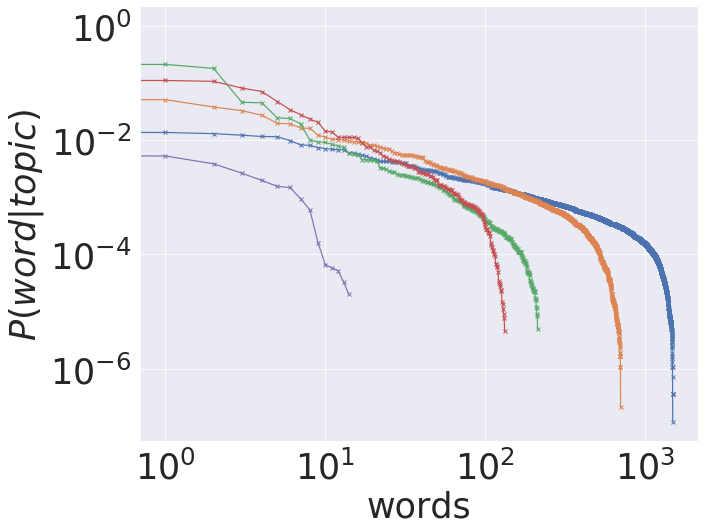

In [34]:
fig=plt.figure(figsize=(10,8))
plt.title("")
for topic in df_Pwt.columns[:5]:
    dist = df_Pwt.sort_values(by=[topic], ascending=False)[topic].astype(float)
    dist = dist[dist>1e-50].values
    if len(dist)<2:
        pass
    plt.plot(np.sort(dist[dist>0].T)[::-1], marker='x', label=topic)
plt.ylabel("$P(word | topic)$", fontsize=35)
plt.xlabel("words", fontsize=35)
plt.xscale('log')
plt.yscale('log')
plt.tick_params(which="both",labelsize=35)
#plt.legend()
plt.show()
fig.savefig("p_w_tw_%s.pdf"%algorithm)

In [35]:
df_Ptd = pd.read_csv("%s/%s_level_%d_topic-dist.csv"%(algorithm,algorithm,L), index_col=1).drop('i_doc',1)

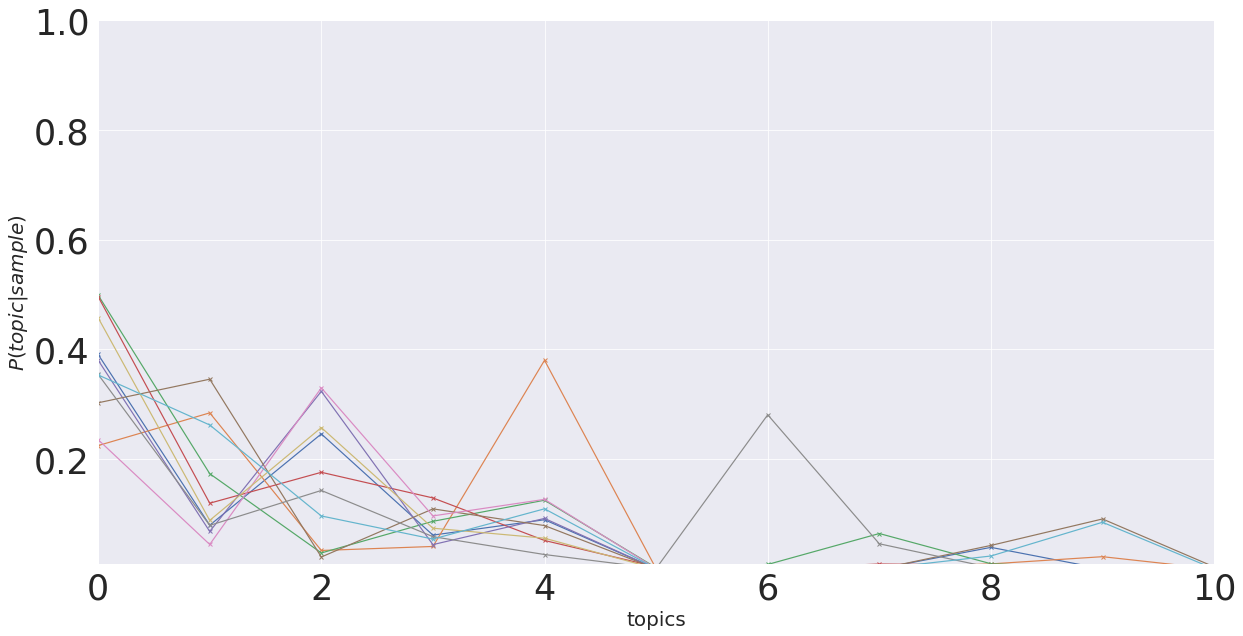

In [36]:
fig=plt.figure(figsize=(20,10))
plt.ylabel("$P(topic | sample$)", fontsize=20)
plt.xlabel("topics", fontsize=20)
for sample in df_Ptd.index.values[:10]:
    plt.plot(df_Ptd.loc[sample,:].astype(float).values, marker='x')
    #plt.plot(np.sort(df_Ptd.filter(F.col('doc')==sample[0]).drop('doc').toPandas().astype(float).values[0])[::-1], lw=0.1, marker='x')
#plt.plot(np.logspace(0,2),1/np.logspace(0,2))
#plt.xscale('log')
#plt.yscale('log')
plt.ylim(1e-2,1)
plt.xlim(0,len(df_Ptd.columns)-2)
plt.tick_params(labelsize=35)
plt.show()
fig.savefig("p_t_s_%s.pdf"%algorithm)

In [39]:
df_mt = pd.read_csv("mainTable.csv",sep=",",index_col=0)
#df_files=pd.read_csv("files.dat", index_col=0)
#df_mt=df_mt.reindex(index=df_Pwt.index.values.ravel(),
#                    columns=[get_file(sample, df_files).name for sample in df_Ptd.index.values.ravel()])
#df_mt.dropna(how="all", axis=0, inplace=True)
#df_mt=df_mt.where(df_mt<1e4,1e4)
df_mt.head()

,dc0ce32f-d5aa-489f-ba4b-e01443815121.FPKM.txt.gz,2b33014e-c7ff-41aa-82bf-3121756639ad.FPKM.txt.gz,397e302e-393e-4f54-b360-fcffe394271e.FPKM.txt.gz,037b5a94-487e-4f5b-90a3-d696eb4a8a3e.FPKM.txt.gz,5e010a9a-7f65-434b-ae4c-43948461187c.FPKM.txt.gz,ae59d924-06ec-428d-b470-e78ed92c5e36.FPKM.txt.gz,2b2b6341-1f6d-4acc-8a67-0ba8ab051ee8.FPKM.txt.gz,87d1452e-8ec6-4c75-a03b-361738c728c0.FPKM.txt.gz,5d420937-4d97-4f04-9ce9-754054261d97.FPKM.txt.gz,c622f68c-e37c-45ee-a266-ae704629f0f6.FPKM.txt.gz,...,90af0faf-3e8c-4741-bf49-f87a5b21d54c.FPKM.txt.gz,3b1e8e56-f2a3-4a3f-8f99-ba8a8f33152c.FPKM.txt.gz,26918c74-1269-4f63-a871-57855b4aa846.FPKM.txt.gz,ef6e0187-ca29-4c32-9731-4f9a6b51ff80.FPKM.txt.gz,c8fb3217-2cc9-47c0-84b6-b666c07624e6.FPKM.txt.gz,68acaa5e-6a27-499f-925d-710af9d30710.FPKM.txt.gz,ce786209-c77d-47e0-95a6-20c036bed8b3.FPKM.txt.gz,cf792f7f-a3ee-4544-b029-8c4e4da4f973.FPKM.txt.gz,85ac083c-dbb9-4541-8b75-d73ab216f54c.FPKM.txt.gz,b1558748-bec9-4bea-a35b-040ca9a1f4cd.FPKM.txt.gz
0,,,,,,,,,,,,,,,,,,,,,
ENSG00000000938,4.24,2.53,1.90,4.10,20.25,6.07,15.66,1.41,4.82,12.22,...,8.31,3.61,4.01,3.92,3.45,2.46,5.88,16.31,4.70,7.87
ENSG00000001084,11.76,85.19,40.94,0.96,3.06,63.92,3.58,3.87,1.73,17.58,...,58.75,0.83,38.74,7.36,2.11,3.61,9.72,5.45,11.11,13.07
ENSG00000001631,4.21,12.01,2.98,6.13,4.05,7.18,2.92,7.25,7.00,4.35,...,5.14,4.20,6.11,5.57,4.18,3.95,4.55,4.61,4.74,3.90
ENSG00000002933,10.27,4.88,7.64,15.01,14.71,13.49,10.34,5.50,1.68,17.44,...,12.83,11.81,3.30,10.24,29.25,18.49,39.27,110.05,59.16,28.83
ENSG00000003147,8.74,1.71,13.39,5.76,3.18,1.08,3.40,18.29,20.89,3.82,...,12.98,13.43,4.58,3.27,9.63,9.65,9.72,8.00,7.58,2.67


In [40]:
Pgt = tf.convert_to_tensor(df_Pwt.values)
Pts = tf.transpose(tf.convert_to_tensor(df_Ptd.values))
Pgs = tf.matmul(Pgt,Pts)
Ps = tf.convert_to_tensor(df_mt.sum(0).values)
Ps = tf.divide(Ps, tf.reduce_sum(Ps))#normalize
Pg = tf.squeeze(tf.matmul(Pgs, tf.reshape(Ps,[Ps.shape[0],1])))

In [41]:
print(Pgt.shape,Pts.shape,Pgs.shape,Pg.shape, Ps.shape)

(3000, 12) (12, 408) (3000, 408) (3000,) (408,)


In [42]:
Pgs_data = Pgs.numpy()
Pg_data = Pg.numpy()
Pgs_data.shape

(3000, 408)

In [43]:
df_Pgs = pd.DataFrame(data=Pgs_data, index=df_Pwt.values.T[0], columns=df_Ptd.index.values.ravel())

In [44]:
A=df_mt.fillna(0).astype(int).sum(1).values

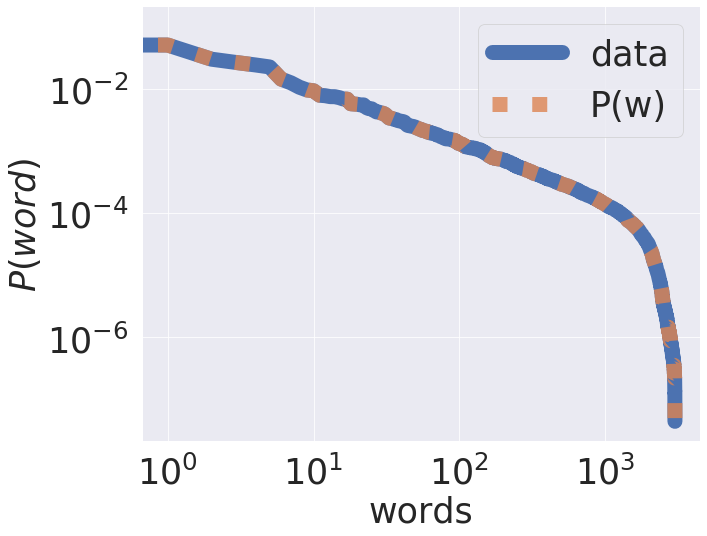

In [47]:
fig=plt.figure(figsize=(10,8))
plt.plot(np.sort(A)[::-1]/A.sum(), lw=15, ls='-', label='data')
plt.plot(np.sort(Pg_data)[::-1]/np.sum(Pg_data), alpha=0.8, lw=15, ls=':', label='P(w)')
plt.ylabel("$P(word$)", fontsize=35)
plt.xlabel("words", fontsize=35)
plt.xscale('log')
plt.yscale('log')
plt.tick_params(labelsize=35)
plt.tick_params(which="both", width=25, length=10, labelsize=35)
plt.legend(fontsize=35)
plt.show()
fig.savefig("p_w_%s.pdf"%algorithm)